<a href="https://colab.research.google.com/github/mbadiee/Sleep-Apnea-Detection-By-DL-Algorithm-/blob/main/1_LeNet_5_CNN_Apnea_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d bettycxh06/apnea-ecg-database
!kaggle kernels pull bettycxh06/rri-amplitudes

apnea-ecg-database.zip: Skipping, found more recently modified local copy (use --force to force download)
Source code downloaded to /content/rri-amplitudes.ipynb


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [ ]:
os.listdir(os.getcwd())

['.config',
 'apnea-ecg-database-1.0.0',
 'models',
 'model.png',
 'apnea-ecg-database.zip',
 'event-2-answers',
 'rri-amplitudes.ipynb',
 'kaggle (1).json',
 'kaggle.json',
 'sample_data']

In [ ]:
!unzip apnea-ecg-database.zip

Archive:  apnea-ecg-database.zip
replace apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/ANNOTATORS? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/ANNOTATORS  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/RECORDS  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/SHA256SUMS.txt  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01.apn  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01.dat  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01.hea  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01.qrs  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01.xws  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01er.apn  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01er.hea  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01er.qrs  
  inflating: apnea-ecg-database-1.0.0/

In [ ]:

!pip install biosppy
!pip install wfdb

from IPython.display import display
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
import os
import shutil
import posixpath
import csv
import wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pickle
import sys
from concurrent.futures import ProcessPoolExecutor, as_completed

import biosppy.signals.tools as st
import numpy as np
import os
import wfdb
from biosppy.signals.ecg import correct_rpeaks, hamilton_segmenter
from scipy.signal import medfilt
from tqdm import tqdm

# PhysioNet Apnea-ECG dataset
# url: https://physionet.org/physiobank/database/apnea-ecg/
#base_dir = "../input/apnea-ecg-database/apnea-ecg-database-1.0.0"
base_dir = "apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0"
#base_dir = "physionet.org/files/apnea-ecg/1.0.0"



fs = 100
sample = fs * 60  # 1 min's sample points

before = 2  # forward interval (min)
after = 2  # backward interval (min)
hr_min = 20
hr_max = 300

num_worker = 35


def worker(name, labels):
    X = []
    y = []
    groups = []
    signals = wfdb.rdrecord(os.path.join(base_dir, name), channels=[0]).p_signal[:, 0]
    for j in tqdm(range(len(labels)), desc=name, file=sys.stdout):
        if j < before or \
                (j + 1 + after) > len(signals) / float(sample):
            continue
        signal = signals[int((j - before) * sample):int((j + 1 + after) * sample)]
        signal, _, _ = st.filter_signal(signal, ftype='FIR', band='bandpass', order=int(0.3 * fs),
                                        frequency=[3, 45], sampling_rate=fs)
        # Find R peaks
        rpeaks, = hamilton_segmenter(signal, sampling_rate=fs)
        rpeaks, = correct_rpeaks(signal, rpeaks=rpeaks, sampling_rate=fs, tol=0.1)
        if len(rpeaks) / (1 + after + before) < 40 or \
                len(rpeaks) / (1 + after + before) > 200:  # Remove abnormal R peaks signal
            continue
        # Extract RRI, Ampl signal
        rri_tm, rri_signal = rpeaks[1:] / float(fs), np.diff(rpeaks) / float(fs)
        rri_signal = medfilt(rri_signal, kernel_size=3)
        ampl_tm, ampl_siganl = rpeaks / float(fs), signal[rpeaks]
        hr = 60 / rri_signal
        # Remove physiologically impossible HR signal
        if np.all(np.logical_and(hr >= hr_min, hr <= hr_max)):
            # Save extracted signal
            X.append([(rri_tm, rri_signal), (ampl_tm, ampl_siganl)])
            y.append(0. if labels[j] == 'N' else 1.)
            groups.append(name)
    return X, y, groups


if __name__ == "__main__":
    apnea_ecg = {}

    names = [
        "a01", "a02", "a03", "a04", "a05", "a06", "a07", "a08", "a09", "a10",
        "a11", "a12", "a13", "a14", "a15", "a16", "a17", "a18", "a19", "a20",
        "b01", "b02", "b03", "b04", "b05",
        "c01", "c02", "c03", "c04", "c05", "c06", "c07", "c08", "c09", "c10"
    ]

    o_train = []
    y_train = []
    groups_train = []
    print('Training...')
    with ProcessPoolExecutor(max_workers=num_worker) as executor:
        task_list = []
        for i in range(len(names)):
            labels = wfdb.rdann(os.path.join(base_dir, names[i]), extension="apn").symbol
            task_list.append(executor.submit(worker, names[i], labels))

        for task in as_completed(task_list):
            X, y, groups = task.result()
            o_train.extend(X)
            y_train.extend(y)
            groups_train.extend(groups)

    print()



    answers = {}
    with open(os.path.join("event-2-answers"), "r") as f:
    #    with open(os.path.join(base_dir, "event-2-answers"), "r") as f:
        for answer in f.read().split("\n\n"):
            answers[answer[:3]] = list("".join(answer.split()[2::2]))

    names = [
        "x01", "x02", "x03", "x04", "x05", "x06", "x07", "x08", "x09", "x10",
        "x11", "x12", "x13", "x14", "x15", "x16", "x17", "x18", "x19", "x20",
        "x21", "x22", "x23", "x24", "x25", "x26", "x27", "x28", "x29", "x30",
        "x31", "x32", "x33", "x34", "x35"
    ]

    o_test = []
    y_test = []
    groups_test = []
    print("Testing...")
    with ProcessPoolExecutor(max_workers=num_worker) as executor:
        task_list = []
        for i in range(len(names)):
            labels = answers[names[i]]
            task_list.append(executor.submit(worker, names[i], labels))

        for task in as_completed(task_list):
            X, y, groups = task.result()
            o_test.extend(X)
            y_test.extend(y)
            groups_test.extend(groups)

    apnea_ecg = dict(o_train=o_train, y_train=y_train, groups_train=groups_train, o_test=o_test, y_test=y_test,
                     groups_test=groups_test)
    with open(os.path.join(base_dir, "apnea-ecg.pkl"), "wb") as f:
        pickle.dump(apnea_ecg, f, protocol=2)

    print("\nok!")

Training...
a17: 100%|██████████| 485/485 [1:06:22<00:00,  8.21s/it]

Testing...
x12: 100%|██████████| 527/527 [1:07:48<00:00,  7.72s/it]

ok!


In [ ]:
!pip install keras
!pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
"""NOTES: Batch data is different each time in keras, which result in slight differences in results."""
import pickle

import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from tensorflow.keras.models import Model, load_model, save_model
from keras.layers import Input

from keras.regularizers import l2
from scipy.interpolate import splev, splrep
import pandas as pd

#base_dir = "dataset"
base_dir = "apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0"


ir = 3 # interpolate interval
before = 2
after = 2

# normalize
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))


def load_data():
    tm = np.arange(0, (before + 1 + after) * 60, step=1 / float(ir))

    with open(os.path.join(base_dir, "apnea-ecg.pkl"), 'rb') as f: # read preprocessing result
        apnea_ecg = pickle.load(f)

    x_train = []
    o_train, y_train = apnea_ecg["o_train"], apnea_ecg["y_train"]
    groups_train = apnea_ecg["groups_train"]
    for i in range(len(o_train)):
        (rri_tm, rri_signal), (ampl_tm, ampl_siganl) = o_train[i]
		# Curve interpolation
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_siganl), k=3), ext=1)
        x_train.append([rri_interp_signal, ampl_interp_signal])
    x_train = np.array(x_train, dtype="float32").transpose((0, 2, 1)) # convert to numpy format
    y_train = np.array(y_train, dtype="float32")

    x_test = []
    o_test, y_test = apnea_ecg["o_test"], apnea_ecg["y_test"]
    groups_test = apnea_ecg["groups_test"]
    for i in range(len(o_test)):
        (rri_tm, rri_signal), (ampl_tm, ampl_siganl) = o_test[i]
		# Curve interpolation
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_siganl), k=3), ext=1)
        x_test.append([rri_interp_signal, ampl_interp_signal])
    x_test = np.array(x_test, dtype="float32").transpose((0, 2, 1))
    y_test = np.array(y_test, dtype="float32")
    #print(x_train.shape, y_train.shape, groups_train.shape)
    #print(x_test.shape, y_test.shape, groups_test.shape)
    return x_train, y_train, groups_train, x_test, y_test, groups_test

#X_train = np.expand_dims(dataset.values[:, :-1], axis=2)
#y_train = dataset.values[:, -1:]
#
#X_test = np.expand_dims(dataset.values[:, 1:], axis=2)

train num: 16709
test num: 16945
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 900, 2)]          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 448, 32)           352       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 149, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 73, 64)            10304     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 24, 64)           0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)      

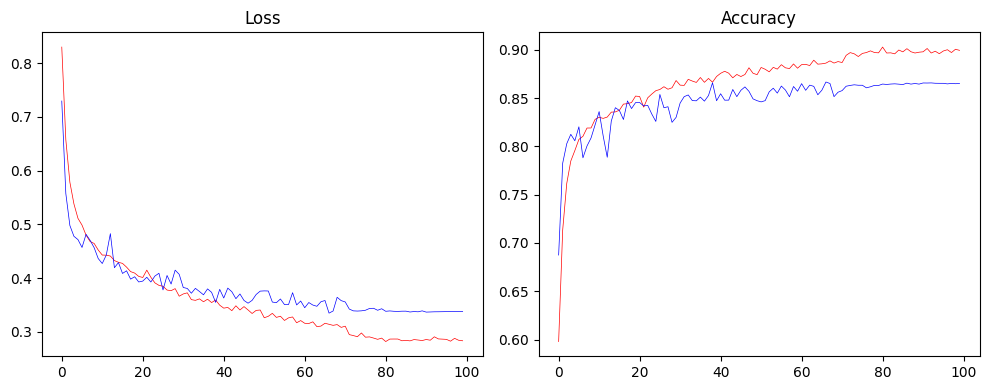

In [ ]:
def create_model(input_shape, weight=1e-3):
	  #"""Create a Modified LeNet-5 model"""
    inputs = Input(shape=input_shape)

	  # Conv1
    x = Conv1D(32, kernel_size=5, strides=2, padding="valid", activation="relu", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(inputs)
    x = MaxPooling1D(pool_size=3)(x)

	  # Conv3
    x = Conv1D(64, kernel_size=5, strides=2, padding="valid", activation="relu", kernel_initializer="he_normal",
               kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x)
    x = MaxPooling1D(pool_size=3)(x)

    x = Dropout(0.8)(x) # Avoid overfitting

	  # FC6
    x = Flatten()(x)
    x = Dense(32, activation="relu")(x)
    outputs = Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def lr_schedule(epoch, lr):
    if epoch > 70 and \
            (epoch - 1) % 10 == 0:
        lr *= 0.1
    print("Learning rate: ", lr)
    return lr


def plot(history):
	  #"""Plot performance curve"""
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(history["loss"], "r-", history["val_loss"], "b-", linewidth=0.5)
    axes[0].set_title("Loss")
    axes[1].plot(history["accuracy"], "r-", history["val_accuracy"], "b-", linewidth=0.5)
    axes[1].set_title("Accuracy")
    fig.tight_layout()
    fig.show()


if __name__ == "__main__":
    x_train, y_train, groups_train, x_test, y_test, groups_test = load_data()

    y_train = keras.utils.to_categorical(y_train, num_classes=2) # Convert to two categories
    y_test = keras.utils.to_categorical(y_test, num_classes=2)

    print("train num:", len(y_train))
    print("test num:", len(y_test))

    model = create_model(input_shape=x_train.shape[1:])
    model.summary()

    from keras.utils import plot_model

    plot_model(model, "model.png") # Plot model

    #model = keras.utils.multi_gpu_model(model, gpus=2) # Multi-gpu acceleration (optional)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

    lr_scheduler = LearningRateScheduler(lr_schedule) # Dynamic adjustment learning rate
    history = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test),
                        callbacks=[lr_scheduler])
    model.save(os.path.join("models", "model.final.h5")) # Save training model

    loss, accuracy = model.evaluate(x_test, y_test) # test the model
    print("Test loss: ", loss)
    print("Accuracy: ", accuracy)

    # save prediction score
    y_score = model.predict(x_test)
    output = pd.DataFrame({"y_true": y_test[:, 1], "y_score": y_score[:, 1], "subject": groups_test})
    #output.to_csv(os.path.join("output", "LeNet.csv"), index=False)

    plot(history.history)
